[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/15_polygon_fill.ipynb)

In [ ]:
#| default_exp gridding_utils.polygon_fill

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| include: false
#| no_test
![ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| export
from typing import List, Tuple, Set, Optional, Dict, Union

import numpy as np
import pandas as pd
import geopandas as gpd
import polars as pl

In [ ]:
#| hide
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Overview

We will use 2 separate algorithms for filling in pixels in polygons:

1. [Voxel Traversal Algorithm](https://github.com/cgyurgyik/fast-voxel-traversal-algorithm/blob/master/overview/FastVoxelTraversalOverview.md): We use this for filling in pixels along the polygon boundary. 2D voxel traversal is used for every line segment of the polygon boundary.
2. [Scanline Fill Algorithm](https://www.educative.io/answers/what-is-scanline-fill-algorithm): We use this for filling in pixels in the polygon interior.

These algorithms are currently used in `FastSquareGridGenerator` and `FastBingTileGridGenerator`

All pixels and polygon vertices are assumed to have integer coordinates.

In [ ]:
polygon_test_cases = {
    "Square": [(0, 0), (10, 0), (10, 10), (0, 10)],
    "Triangle": [(0, 0), (10, 0), (5, 10)],
    "Right Triangle": [(0, 0), (10, 0), (0, 10)],
    "Pentagon": [(2, 0), (8, 0), (10, 6), (5, 10), (0, 6)],
    "Star": [
        (6, 2),
        (8, 8),
        (12, 8),
        (9, 12),
        (11, 18),
        (6, 14),
        (1, 18),
        (3, 12),
        (0, 8),
        (4, 8),
    ],

    "Complex Shape 1": [(0, 0), (5, 2), (3, 5), (8, 8), (5, 10), (0, 7)],
    "Complex Shape 2": [
        (0, 0),
        (2, 6),
        (4, 10),
        (6, 8),
        (8, 12),
        (10, 4),
        (12, 2),
        (8, 0),
    ],
    "Complex Shape 3": [(2, 3), (5, 3), (6, 6), (3, 7), (1, 5)],
    "Complex Shape 4": [(1, 1), (2, 5), (4, 3), (6, 7)],
    "Complex Shape 5": [(1, 2), (3, 6), (5, 5), (7, 4), (9, 5), (11, 2)],
}

In [ ]:
#| hide
def plot_polygon(
    ax: plt.Axes,
    vertices: List[Tuple[int,int]],
    pixels: Optional[set] = None,
    figsize: tuple = (4, 4),
):
    vertices_x = [x for (x,y) in vertices]
    vertices_y = [y for (x,y) in vertices]
    
    ax.plot(vertices_x, vertices_y, "b-", markersize=5)
    # to close off the polygon
    ax.plot([vertices_x[-1], vertices_x[0]], [vertices_y[-1], vertices_y[0]], "b-")

    if pixels is not None:
        for x, y in pixels:
            rect = patches.Rectangle(
                xy=(x - 0.5, y - 0.5),
                width=1,
                height=1,
                linewidth=1,
                edgecolor="black",
                facecolor="r",
                alpha=0.6,
            )
            ax.add_patch(rect)

def plot_all_polygons(
    polygon_vertices_dict: Dict[str, List[Tuple[int, int]]], 
    polygon_pixels_dict: Dict[str, set], 
    n_imgs_per_row: int = 3,
):
    n = len(polygon_vertices_dict)
    rows = (n + n_imgs_per_row - 1) // n_imgs_per_row 
    fig, axes = plt.subplots(nrows=rows, ncols=n_imgs_per_row, figsize=(4 * n_imgs_per_row, 4 * rows))

    if n_imgs_per_row == 1:
        axes = [axes]  
    
    # Flattening the axes for easier iteration, especially for n_imgs_per_row = 1
    axes_flat = axes.flatten()

    # Iterate over each polygon and its corresponding pixels
    for ax, (name, vertices) in zip(axes_flat, polygon_vertices_dict.items()):
        pixels = polygon_pixels_dict.get(name, set())
        plot_polygon(ax, vertices, pixels)
        ax.set_title(name)
        ax.axis('equal')
    
    for ax in axes_flat[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Voxel Traversal

We use the 2D voxel traversal algorithm to fill in pixels between two points.

In [ ]:
#| export

def voxel_traversal_2d(
    start_vertex: Tuple[int, int], 
    end_vertex: Tuple[int, int],
    debug: bool = False, # if true, prints diagnostic info for the algorithm  
) -> List[Tuple[int, int]]:
    """
    Returns all pixels between two points as inspired by Amanatides & Woo's “A Fast Voxel Traversal Algorithm For Ray Tracing” 
    Implementation adapted from https://www.redblobgames.com/grids/line-drawing/
    """

    # Setup initial conditions
    x1, y1 = start_vertex
    x2, y2 = end_vertex

    direction_x = 1 if x2 > x1 else -1
    direction_y = 1 if y2 > y1 else -1

    # Single point
    if (x1 == x2) and (y1 == y2):
        pixels = [(x1,y1)]
        return pixels

    # Vertical line
    elif x1 == x2:
        pixels = [(x1, y) for y in range(y1, y2 + direction_y, direction_y)]
        return pixels

    # Horizontal line
    elif y1 == y2:
        pixels = [(x, y1) for x in range(x1, x2 + direction_x, direction_x)]
        return pixels

    dy = y2 - y1
    dx = x2 - x1

    pixel_x, pixel_y = x1, y1
    pixels = [(pixel_x, pixel_y)]

    is_finished = False

    if debug:
        print(f"\nTraversing from ({x1},{y1}) to ({x2},{y2})")

    ix = 0
    iy = 0

    nx = abs(dx)
    ny = abs(dy)
    max_steps = (nx+ny)
    n_steps = 0
    while not is_finished:
        # this prevents infinite loops
        n_steps += 1
        if n_steps > max_steps:
            raise Exception(
                f"Traversal has exceeded steps limit {max_steps:,}. Please recheck inputs"
            )

        decision = (1+2*ix)*ny - (1+2*iy)*nx
        if decision == 0:
            # diagonal step
            pixel_x += direction_x
            pixel_y += direction_y
            ix += 1
            iy += 1
        elif decision < 0:
            # horizontal step
            pixel_x += direction_x
            ix += 1
        else:
            # vetical step
            pixel_y += direction_y
            iy += 1

        pixels.append((pixel_x, pixel_y))

        if debug:
            print(
                f"Next tile coords are ({pixel_x}, {pixel_y})"
            )

        # checks to see if the loop is finished
        if direction_x == 1:
            is_x_finished = pixel_x >= x2
        elif direction_x == -1:
            is_x_finished = pixel_x <= x2

        if direction_y == 1:
            is_y_finished = pixel_y >= y2
        elif direction_y == -1:
            is_y_finished = pixel_y <= y2

        if is_x_finished and is_y_finished:
            break
    
    return pixels

Voxel traversal is used on every line segment to fill the polygon boundary.

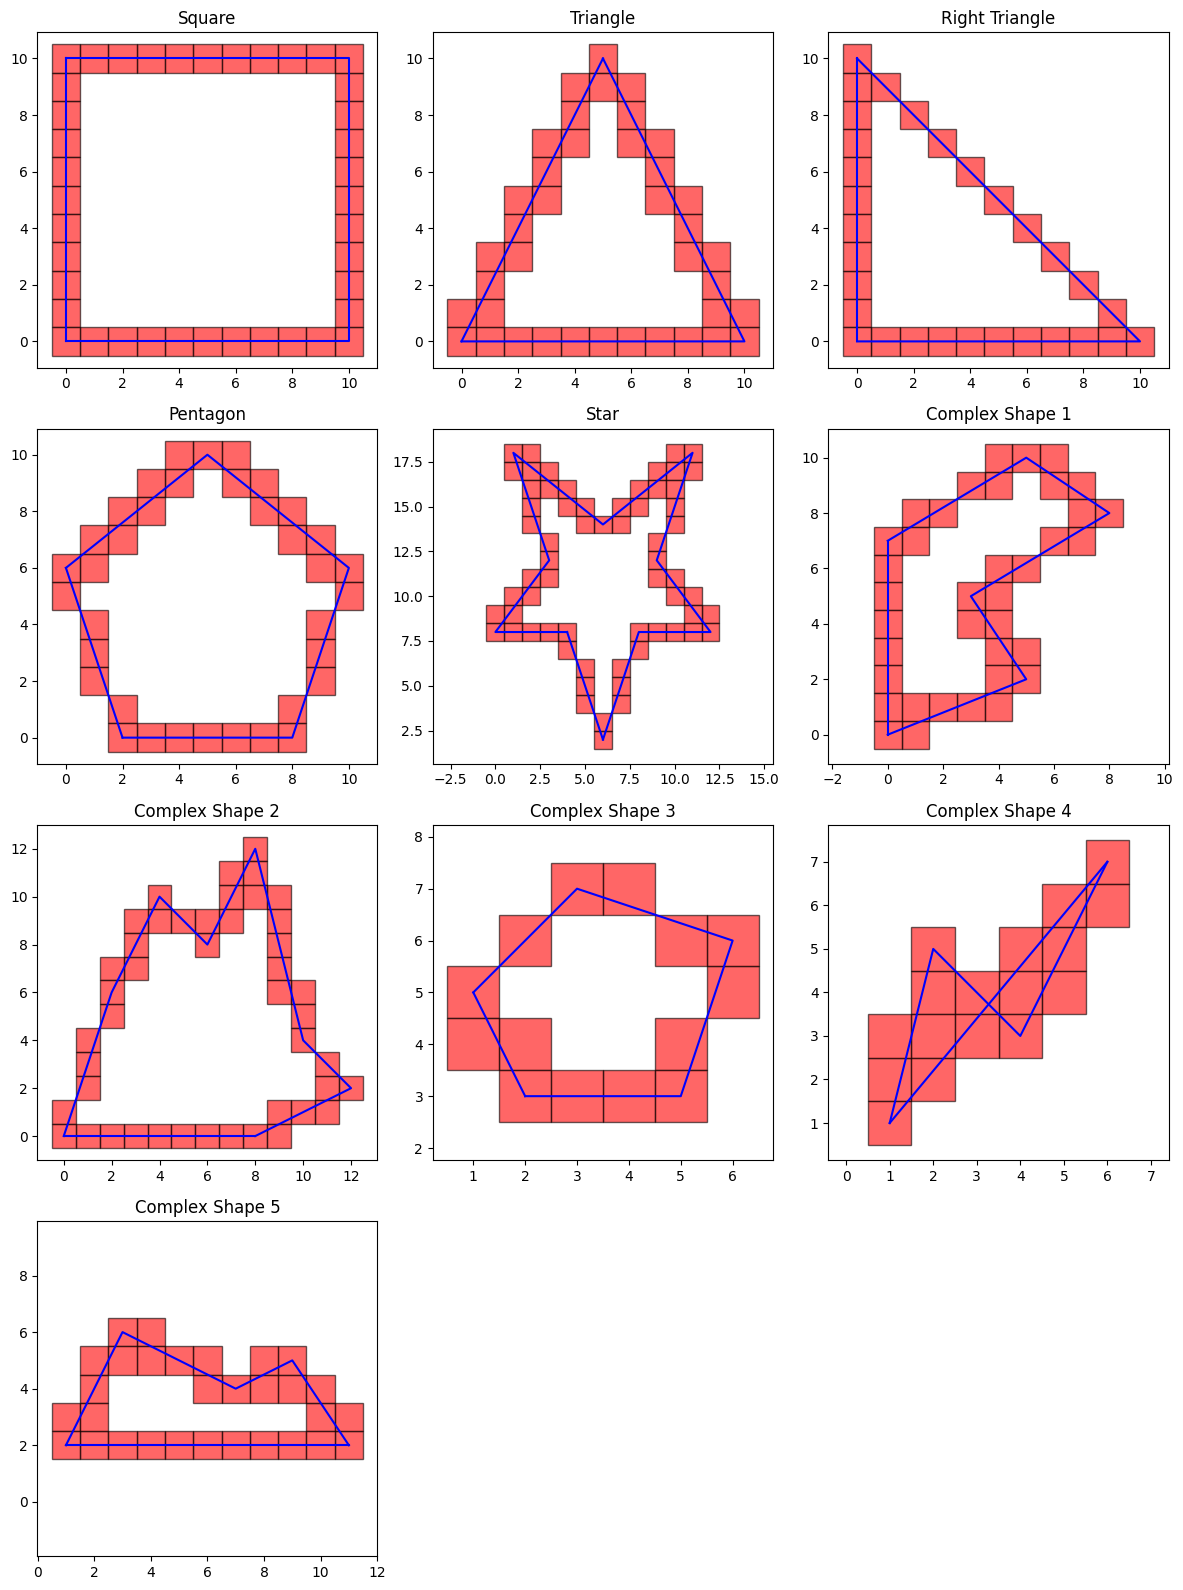

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    offset_vertices = vertices[1:] + vertices[:1]

    pixels = set()
    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        pixels.update(voxel_traversal_2d(start_vertex, end_vertex))

    polygon_pixels[test_polygon_name] = pixels
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Scanline Fill Algorithm

We use the scanline fill algorithm to fill in pixels within the polygon boundary.

In [ ]:
#| exporti
def interpolate_x(
    start_vertex: Tuple[int, int],
    end_vertex: Tuple[int, int],
    y: int,
) -> float:
    """Interpolate x value for a given y along the line segment defined by start_vertex and end_vertex."""
    x1, y1 = start_vertex
    x2, y2 = end_vertex
    if y1 == y2:
        # case when there is a horizontal line segment
        raise ValueError(f"The y value of the 2 vertices should not be the same")

    inverse_slope = (x2 - x1) / (y2 - y1)
    interpolated_x = x1 + (y - y1) * inverse_slope
    return interpolated_x

In [ ]:
#| export
def scanline_fill(
    vertices: List[Tuple[int,int]], # list of polygon vertices in order (either clockwise or counterclockwise)
    debug: bool = False, # if true, prints diagnostic info for the algorithm  
) -> Set[Tuple[int,int]]:
    """Returns all pixels within the interior of a polygon defined by vertices"""
    
    offset_vertices = vertices[1:] + vertices[:1]

    if not vertices:
        return set()
    
    if len(vertices) == 1:
        return set(vertices)

    # Calculate the bounding box for the polygon
    min_y, max_y = min(y for x, y in vertices), max(y for x, y in vertices)

    filled_pixels = set()
    # Process each horizontal scanline within the bounding box
    for scanline_y in range(min_y, max_y + 1):
        intersection_points = []

        # Find intersections of the polygon with the current scanline
        for start_vertex, end_vertex in zip(vertices, offset_vertices):
            start_x, start_y = start_vertex
            end_x, end_y = end_vertex

            if (end_y < scanline_y <= start_y) or (start_y < scanline_y <= end_y):
                # Calculate x-coordinate of intersection
                intersection_x = interpolate_x(start_vertex, end_vertex, scanline_y)
                intersection_points.append(intersection_x)

        # Fill pixels between pairs of intersections
        if intersection_points:
            intersection_points.sort()

            filled_pixels_in_row = set()
            for start_x, end_x in zip(
                intersection_points[::2], intersection_points[1::2]
            ):
                start_x, end_x = int(round(start_x)), int(round(end_x))

                _filled_pixels_in_row = [
                    (x, scanline_y) for x in range(start_x, end_x + 1)
                ]
                filled_pixels_in_row.update(_filled_pixels_in_row)

            filled_pixels.update(filled_pixels_in_row)

        if debug:
            print(f"Scanline y = {scanline_y}, Intersections: {intersection_points}")
    
    return filled_pixels


We use scanline fill on every set of vertices. Notice that the scanline can fill parts of the boundary as well, but it doesn't capture the entire boundary.

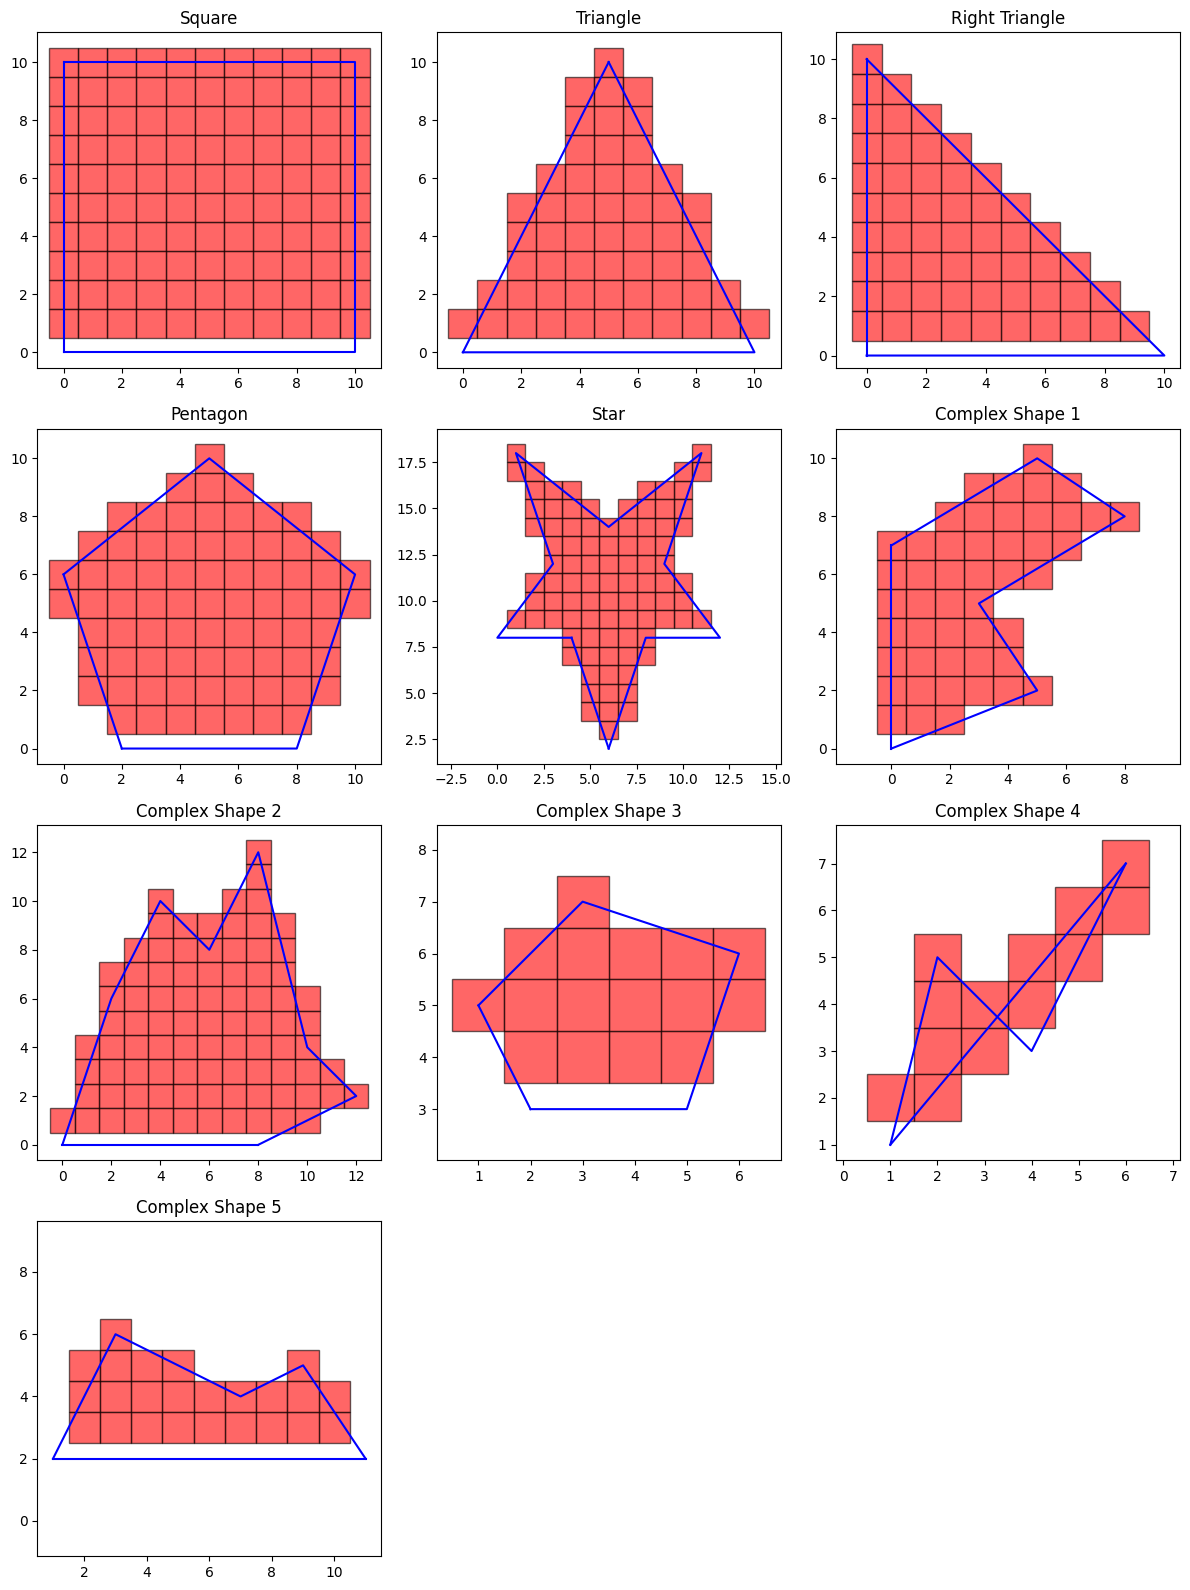

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    polygon_pixels[test_polygon_name] = scanline_fill(vertices)
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Combining Voxel Traversal and Scanline Fill for our Polygon Fill Algorithm

In [ ]:
#| export

def voxel_traversal_scanline_fill(
    vertices_df: Union[pd.DataFrame,pl.DataFrame], # dataframe with x_col and y_col for the polygon vertices
    x_col: str = "x", 
    y_col: str = "y",
    debug: bool = False, # if true, prints diagnostic info for both voxel traversal and scanline fill algorithms
) -> Set[Tuple[int,int]]:
    """
    Returns pixels that intersect a polygon
    This uses voxel traversal to fill the boundary, and scanline fill for the interior. All coordinates are assumed to be integers        
    """

    vertices = list(zip(vertices_df[x_col].to_list(), vertices_df[y_col].to_list()))
    offset_vertices = vertices[1:] + vertices[:1]

    polygon_pixels = set()

    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        polygon_pixels.update(voxel_traversal_2d(start_vertex, end_vertex, debug))
    
    polygon_pixels.update(scanline_fill(vertices, debug))

    return polygon_pixels

By using both algorithms, we can fill all the pixels per polygon.

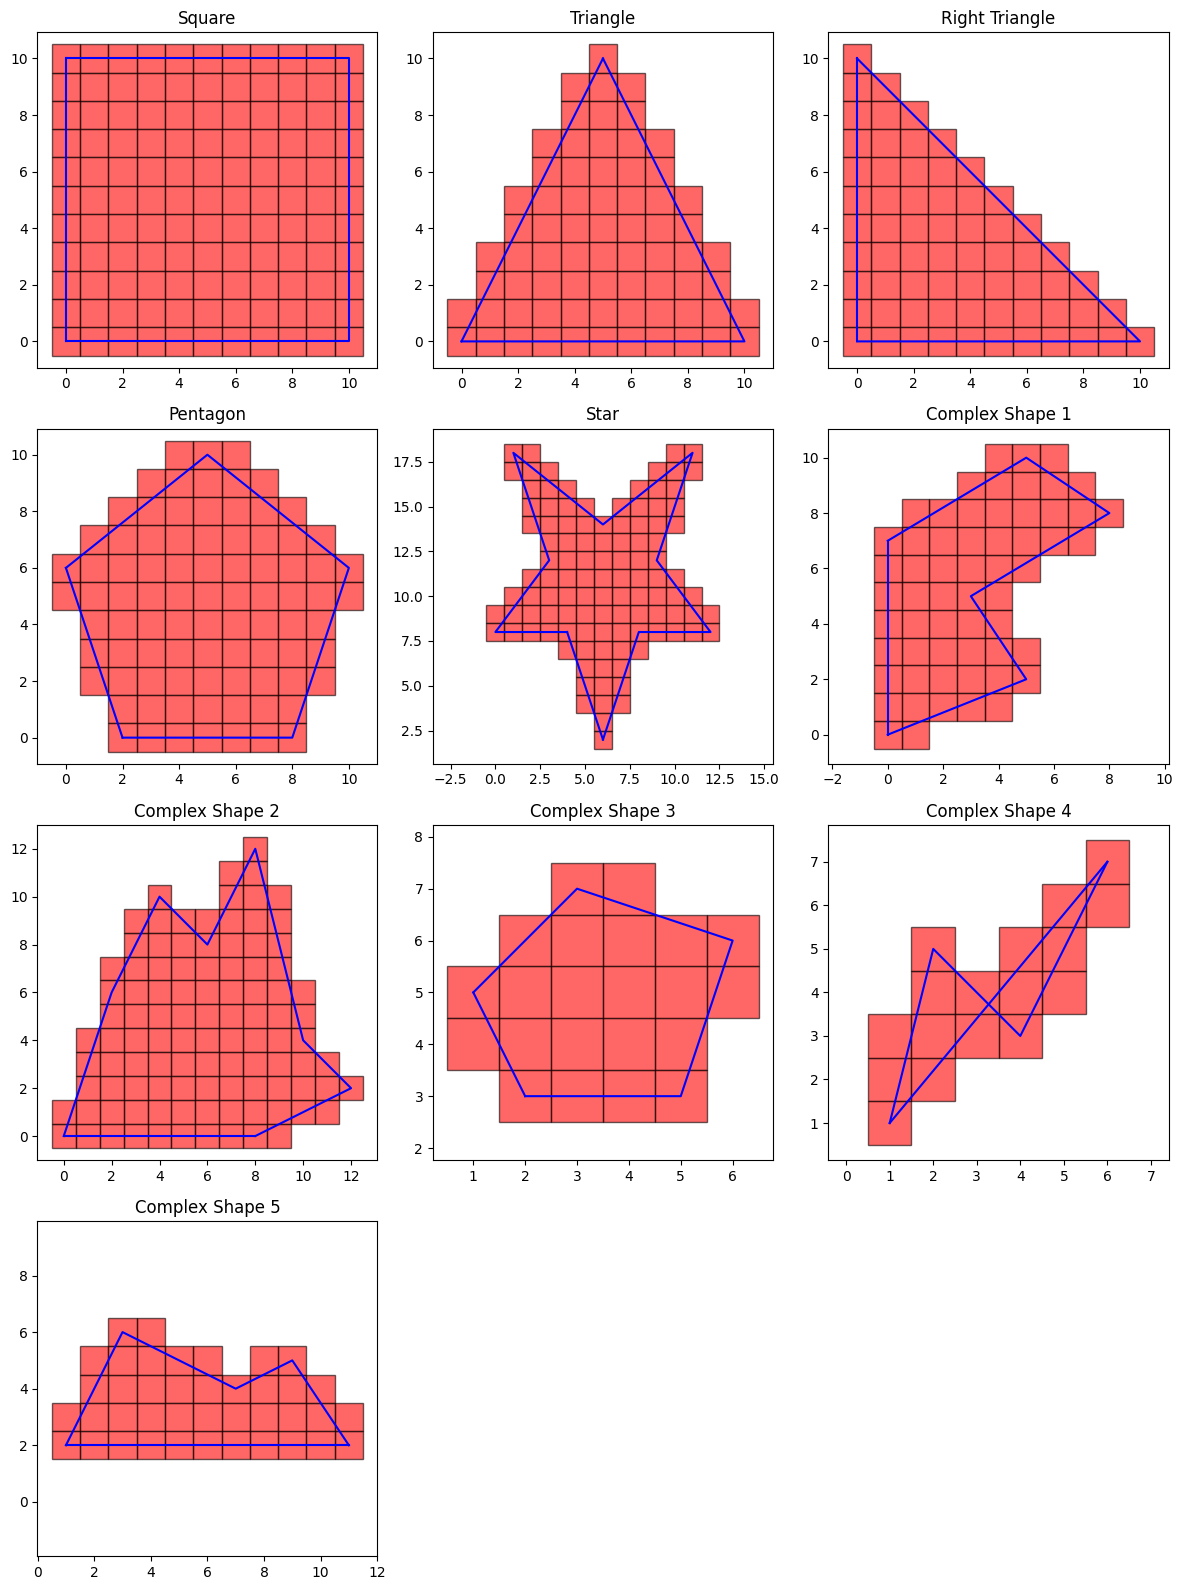

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    vertices_df = pd.DataFrame(vertices, columns=["x", "y"])
    polygon_pixels[test_polygon_name] = voxel_traversal_scanline_fill(vertices_df)
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Filling multiple polygons in a `GeoDataFrame`

For cases where we have multiple polygons or have MultiPolygon objects, we use `voxel_traversal_scanline_fill` over each individual polygon.

In [ ]:
from shapely.geometry import Polygon, MultiPolygon

multipolygon_dict = {
    "Square": Polygon([(15, 0), (25, 0), (25, 10), (15, 10)]),
    "Triangle MultiPolygon": MultiPolygon(polygons = [
        Polygon([(0, 0), (10, 0), (5, 10)]), 
        Polygon([(0, 12), (10, 12), (0, 22)])],
    ),
    "Pentagon": Polygon([(17, 15), (23, 15), (25, 21), (20, 25), (15, 21)]),
}

multipolygon_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(multipolygon_dict))
multipolygon_gdf.index.name = "polygon_name"
multipolygon_gdf = multipolygon_gdf.reset_index()
multipolygon_gdf 

,polygon_name,geometry
0,Square,"POLYGON ((15 0, 25 0, 25 10, 15 10, 15 0))"
1,Triangle MultiPolygon,"MULTIPOLYGON (((0 0, 10 0, 5 10, 0 0)), ((0 12..."
2,Pentagon,"POLYGON ((17 15, 23 15, 25 21, 20 25, 15 21, 1..."


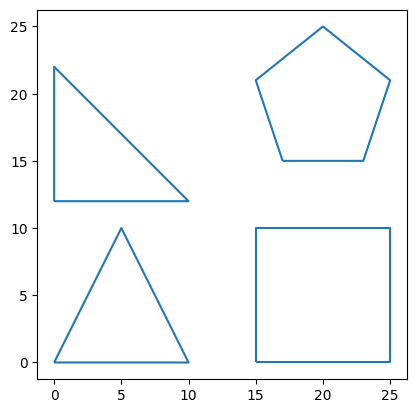

In [ ]:
multipolygon_gdf.boundary.plot()
plt.show()

### Converting `Polygons` and `MultiPolygons` to a list of vertices 

The `polygons_to_vertices` can convert all polygons and multipolygons in a GeoDataFrame to a Polars DataFrame of vertices. (It is also feasible to convert it to a Pandas DataFrame but using Polars is more efficient.)

In [ ]:
#| exporti
SUBPOLYGON_ID_COL =  "__subpolygon_id__"
PIXEL_DTYPE = pl.Int32

In [ ]:
#| export
def polygons_to_vertices(
    polys_gdf: gpd.GeoDataFrame, 
    unique_id_col: Optional[str] = None # the ids under this column will be preserved in the output tiles
) -> pl.DataFrame:
    
    if unique_id_col is not None:
        duplicates_bool = polys_gdf[unique_id_col].duplicated()
        if duplicates_bool.any():
            raise ValueError(
                f"""{unique_id_col} is not unique!
                Found {duplicates_bool.sum():,} duplicates"""
            )
        polys_gdf = polys_gdf.set_index(unique_id_col)
    else:
        # reset index if it is not unique
        if polys_gdf.index.nunique() != len(polys_gdf.index):
            polys_gdf = polys_gdf.reset_index(drop=True)
        unique_id_col = polys_gdf.index.name

    polys_gdf = polys_gdf.explode(index_parts=True)

    is_poly_bool = polys_gdf.type == "Polygon"
    if not is_poly_bool.all():
        raise ValueError(
            f"""
        All geometries should be polygons or multipolygons but found
        {is_poly_bool.sum():,} after exploding the GeoDataFrame"""
        )

    polys_gdf.index.names = [unique_id_col, SUBPOLYGON_ID_COL]
    vertices_df = polys_gdf.get_coordinates().reset_index()
    vertices_df = pl.from_pandas(vertices_df)

    return vertices_df

The output is a dataframe of vertices across all polygons. 

If the original coordinates are based on a geographic coordinate system such as `epsg:4326` or `epsg:3857`, then there would normally need to be an additional step to translate it from geographic coordinates to integer coordinates. But since our sample polygons are already based on integer coordinates, then we only need to cast the vertex coordinates `x`, `y` to an integer dtype.

In [ ]:
vertices_df = polygons_to_vertices(multipolygon_gdf, "polygon_name")
vertices_df = vertices_df.cast({"x":PIXEL_DTYPE, "y":PIXEL_DTYPE})
vertices_df.head()

polygon_name,__subpolygon_id__,x,y
str,i64,i32,i32
"""Square""",0,15,0
"""Square""",0,25,0
"""Square""",0,25,10
"""Square""",0,15,10
"""Square""",0,15,0


### Getting pixels within each polygon

The `fast_polygon_fill` is generally a wrapper on `voxel_traversal_scanline_fill` to find all pixel coordinates within each polygon in the AOI. 

In [ ]:
#| export

def fast_polygon_fill(
    vertices_df: pl.DataFrame, # integer vertices of all polygons in the AOI
    unique_id_col: Optional[str] = None, # the ids under this column will be preserved in the output tiles
) -> pl.DataFrame:
    
    if unique_id_col is not None:
        id_cols = [SUBPOLYGON_ID_COL, unique_id_col]
        has_unique_id_col = True
    else:
        complement_cols = ["x","y",SUBPOLYGON_ID_COL]
        unique_id_col = list(set(vertices_df.columns) - set(complement_cols))
        assert len(unique_id_col) == 1
        unique_id_col = unique_id_col[0]
        id_cols = [SUBPOLYGON_ID_COL, unique_id_col]
        has_unique_id_col = False

    for col in id_cols:
        assert col in vertices_df, f"{col} should be column in vertices_df"

    polygon_ids = vertices_df.select(id_cols).unique(maintain_order=True).rows()

    tiles_in_geom = set()
    for polygon_id in polygon_ids:
        subpolygon_id, unique_id = polygon_id
        filter_expr = (pl.col(SUBPOLYGON_ID_COL) == subpolygon_id) & (
            pl.col(unique_id_col) == unique_id
        )
        poly_vertices = vertices_df.filter(filter_expr)
        
        poly_vertices = poly_vertices.unique(maintain_order=True)
        _tiles_in_geom = voxel_traversal_scanline_fill(poly_vertices, x_col="x", y_col="y")

        if has_unique_id_col:
            _tiles_in_geom = [(x, y, unique_id) for (x, y) in _tiles_in_geom]

        tiles_in_geom.update(_tiles_in_geom)

    schema = {"x": PIXEL_DTYPE, "y": PIXEL_DTYPE}
    if has_unique_id_col:
        schema[unique_id_col] = vertices_df[unique_id_col].dtype

    tiles_in_geom = pl.from_records(
        data=list(tiles_in_geom),
        orient="row",
        schema=schema,
    )

    return tiles_in_geom

The output is a polars datafarame containing all the pixels within all the AOI polygons. The `unique_id_col` parameter can be used to assign to each pixel its corresponding polygon name from the original AOI. This saves us effort from having to perform another spatial join to get the polygon names.

Normally, if the original AOI is based on a geographic coordinate system such as `epsg:4326` or `epsg:3857`, then there would normally need to be an additional step to translate it from integer coordinates back to geographic coordinates. But in this case it's not necessary since the original AOIs are already based on integer coordinates.

In [ ]:
filled_polygons = fast_polygon_fill(vertices_df, "polygon_name")
filled_polygons.head()

x,y,polygon_name
i32,i32,str
17,19,"""Pentagon"""
6,12,"""Triangle MultiPolygon"""
15,8,"""Square"""
22,21,"""Pentagon"""
1,0,"""Triangle MultiPolygon"""


In [ ]:
# counting pixels per geometry
filled_polygons.group_by("polygon_name").len()

polygon_name,len
str,u32
"""Triangle MultiPolygon""",137
"""Pentagon""",87
"""Square""",121


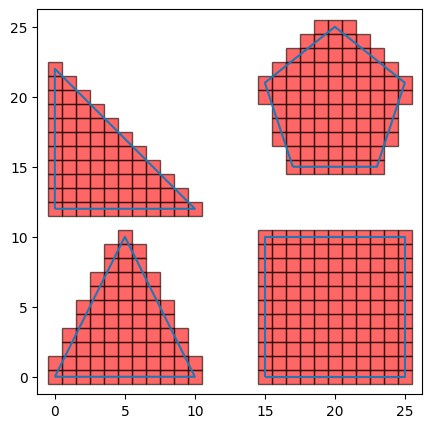

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax = multipolygon_gdf.boundary.plot(ax = ax)
for idx, row in filled_polygons.to_pandas().iterrows():
    x = row["x"]
    y = row["y"]
    rect = patches.Rectangle(
                xy=(x - 0.5, y - 0.5),
                width=1,
                height=1,
                linewidth=1,
                edgecolor="black",
                facecolor="r",
                alpha=0.6,
            )
    ax.add_patch(rect)
plt.show()